In [1]:
!pip install kaggle

In [2]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download paultimothymooney/chest-xray-pneumonia
unzip -qq "chest-xray-pneumonia.zip"
mv "chest_xray/train" "train"
mv "chest_xray/test" "test"
mv "chest_xray/val" "val"
mv "val" "valid"
rm -Rf "chest_xray" "sample_data"
mv "test/NORMAL" "test/normal"
mv "test/PNEUMONIA" "test/pneumonia"
mv "train/NORMAL" "train/normal"
mv "train/PNEUMONIA" "train/pneumonia"
mv "valid/PNEUMONIA" "valid/pneumonia"
mv "valid/NORMAL" "valid/normal"


100%|██████████| 2.29G/2.29G [01:52<00:00, 21.8MB/s]


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import matplotlib.pyplot as plt

In [4]:
# load dataset - train, test and valid
train=tf.keras.utils.image_dataset_from_directory('train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(299,299),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='training',seed=8,)
valid=tf.keras.utils.image_dataset_from_directory('valid',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(299,299),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='validation',seed=8,)
test=tf.keras.utils.image_dataset_from_directory('test',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                 batch_size=32,image_size=(299,299),shuffle=False,validation_split=0.0,
                                                 interpolation='bilinear',subset=None,seed=8,)
print('Total training images:',train.cardinality()*32)
print('Total validation images:',valid.cardinality()*32)
print('Total test images:',test.cardinality()*32)
training_classes:list=train.class_names
valid_classses:list=valid.class_names
test_classes:list=test.class_names
assert training_classes==valid_classses==test_classes,'class count in train, valid and test set is not same'
print('Class names:',training_classes)

Found 5216 files belonging to 2 classes.
Using 3652 files for training.
Found 16 files belonging to 2 classes.
Using 4 files for validation.
Found 624 files belonging to 2 classes.
Total training images: tf.Tensor(3680, shape=(), dtype=int64)
Total validation images: tf.Tensor(32, shape=(), dtype=int64)
Total test images: tf.Tensor(640, shape=(), dtype=int64)
Class names: ['normal', 'pneumonia']


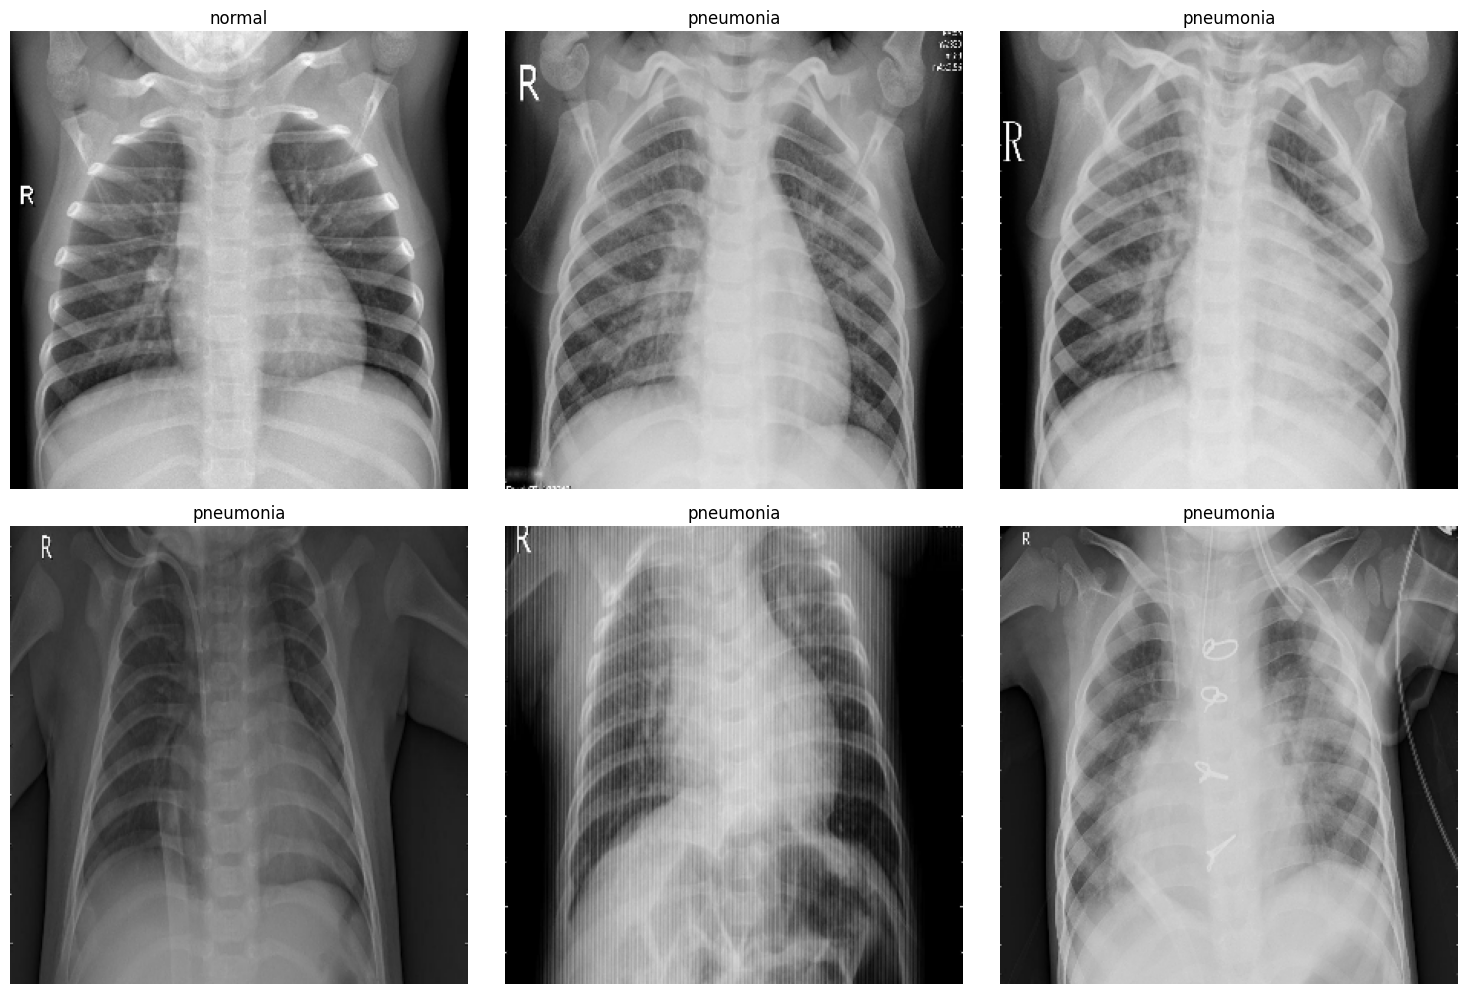

In [5]:
# make plot data training data
for images,labels in train.take(1):break                                        # get a batch of data
images_to_plot:int=6                                                            # number of images to plot
plt.figure(figsize=(15,15))                                                     # figure size
for index in range(images_to_plot):                                             # loop over image index
  plt.subplot(3,3,index+1)                                                      # subplot rows = 3, columns = 3
  plt.imshow(images[index].numpy().astype('uint8'))                             # make plot image
  plt.axis('off')                                                               # make axis off
  plt.title(training_classes[labels[index].numpy()])                            # make add labels as class names
plt.tight_layout()                                                              # adjust layout space
plt.show()

In [6]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)

Maximum pixel values: tf.Tensor(255.0, shape=(), dtype=float32)
Minimum pixel values: tf.Tensor(0.0, shape=(), dtype=float32)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'float32'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int32'>


In [7]:
# make apply data augmentation to data (add more randomness to data)
# source: https://www.tensorflow.org/tutorials/images/data_augmentation
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')# random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')# random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')          # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')# random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]         # make list of data augmentation
# make apply augmentation on training data
for augmentation in augmentations:
  train.map(lambda images,labels: (augmentation(images),labels))                # make apply augmentation

In [8]:
base_model=tf.keras.applications.Xception(include_top=False,weights='imagenet',input_shape=(299,299,3))  # laod base model - VGG16
#base_model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=False,layer_range=None)# print base model summary
base_model.trainable=False                                                                            # make freeze base

83683744/83683744 [==============================] - 5s 0us/step


In [9]:
inputs=tf.keras.layers.Input(shape=(299,299,3),batch_size=None,name='model_inputs')                                 # add input layer
model_x=tf.keras.layers.Rescaling(1/255,offset=0.0,name='rescaler')(inputs)                                         # rescale inputs
model_x=base_model(model_x)                                                                                         # feed inputs to base model
model_x=tf.keras.layers.Flatten(name='flatten')(model_x)                                                            # make flatten outputs
model_x=tf.keras.layers.Dense(1024,activation='relu')(model_x)                                                      # apply dense layer
outputs=tf.keras.layers.Dense(len(training_classes),activation='softmax')(model_x)                                  # output layer
model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_exception')                                         # build model
model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None) # print model summary

Model: "custom_exception"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 model_inputs (InputLayer)                            [(None, 299, 299, 3)]                           0                 Y          
                                                                                                                                   
 rescaler (Rescaling)                                 (None, 299, 299, 3)                             0                 Y          
                                                                                                                                   
 xception (Functional)                                (None, 10, 10, 2048)                            20861480          N          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [10]:
# make compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [11]:
# make early stopping
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,mode='auto',restore_best_weights=True)

# make train model
history=model.fit(train,batch_size=32,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=valid,
                  shuffle=True)

Epoch 1/10000
115/115 - 51s - loss: 3.6993 - sparse_categorical_accuracy: 0.9340 - val_loss: 3.8743e-07 - val_sparse_categorical_accuracy: 1.0000 - 51s/epoch - 448ms/step
Epoch 2/10000
115/115 - 33s - loss: 0.2291 - sparse_categorical_accuracy: 0.9784 - val_loss: 6.5197 - val_sparse_categorical_accuracy: 0.5000 - 33s/epoch - 283ms/step
Epoch 3/10000
115/115 - 31s - loss: 0.0829 - sparse_categorical_accuracy: 0.9877 - val_loss: 2.2422 - val_sparse_categorical_accuracy: 0.7500 - 31s/epoch - 273ms/step
Epoch 4/10000
115/115 - 33s - loss: 0.1631 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.0018 - val_sparse_categorical_accuracy: 1.0000 - 33s/epoch - 286ms/step
Epoch 5/10000
115/115 - 34s - loss: 0.0315 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000 - 34s/epoch - 293ms/step
Epoch 6/10000
115/115 - 32s - loss: 0.0111 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0632 - val_sparse_categorical_accuracy: 1.0000 - 32s/epoch - 2

In [12]:
# see model history (first five epoches)
pd.DataFrame(history.history).head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,3.699297,0.934009,3.874299e-07,1.00
1,0.229086,0.978368,6.519673e+00,0.50
2,0.082883,0.987678,2.242224e+00,0.75
3,0.163138,0.979737,1.773623e-03,1.00
4,0.031471,0.993428,0.000000e+00,1.00


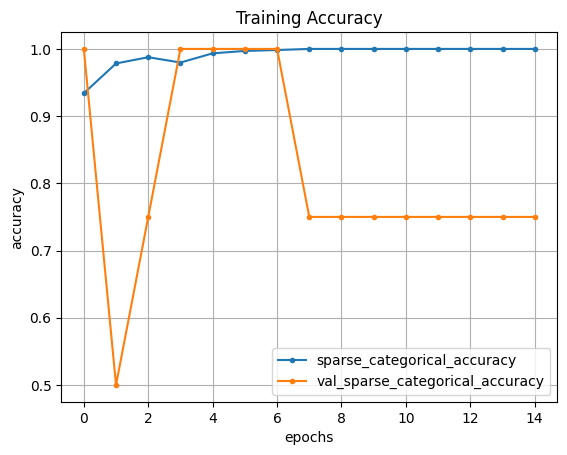

In [13]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')# make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')# add grid, title and axis labels
plt.show()                                                                      # make plot showv

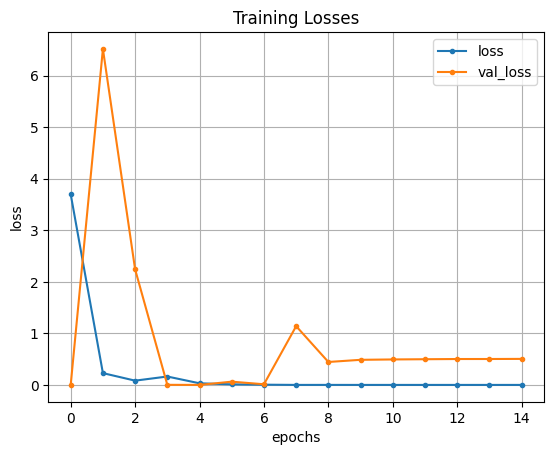

In [14]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')             # make plot
plt.grid(),plt.title('Training Losses'),plt.xlabel('epochs'),plt.ylabel('loss') # add grid, title and axis labels
plt.show()

In [15]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)                                               # make print results

20/20 [==============================] - 7s 314ms/step - loss: 2.1303 - sparse_categorical_accuracy: 0.8798
Testing results: {'loss': 2.1303296089172363, 'sparse_categorical_accuracy': 0.879807710647583}


In [16]:
# make save model (weights and configuration)
model.save('pneumonia_detection_exception',overwrite=True,save_format=None)               # make save

In [19]:
!zip -r -qq "pneumonia_detection_exception.zip" "pneumonia_detection_exception"                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('pneumonia_detection_exception.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>